<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 50px"><b>But de ce Notebook</b></h2>
<p style="font-family: Arial, sans-serif; font-size: 20px; color: white;">
Dans ce notebook, nous définirons la notion de sinistralité et construirons une base de données répertoriant la sinistralité annuelle, région par région, de 2020 à 2024.
</p>

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Définition de la sinistralité</b></h2>

<p style="font-family: Arial, sans-serif; font-size: 20px; color:white;">
En nous inspirant de la bibliographie 2, nous définissons le ratio de sinistralité de la façon suivante:</p>

$$
\text{dérive de sinistralité(N/N-1)} = \frac{RAC_{N}}{RAC_{N-1}} -1\\

\text{où $RAC_{N}$ est le reste à charge par personne à l'année N}\\

\text{et $RAC_{N-1}$ est le reste à charge par personne à l'année N-1}
$$



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Dictionnaires nécessaires</b></h2>

In [6]:
region_mapping = {
    5: "Régions et Départements d'outre-mer",
    11: "Ile-de-France",
    24: "Centre-Val-de-Loire",
    27: "Bourgogne-Franche-Comté",
    28: "Normandie",
    32: "Hauts-de-France",
    44: "Grand Est",
    52: "Pays de la Loire",
    53: "Bretagne",
    75: "Nouvelle-Aquitaine",
    76: "Occitanie",
    84: "Auvergne-Rhône-Alpes",
    93: "Provence-Alpes-Côte d'Azur et Corse"
}

demographie_mapping = {}

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Importation des librairies nécessaires</b></h2>

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, gamma, skewnorm
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.simplefilter('ignore', category=UserWarning)


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données et leurs visualisations</b></h2>

In [8]:
df = pd.read_csv("../../page 3/RAC_nouveau_2.csv")

Aperçu des données

In [9]:
df.head()

,SOI_ANN,SOI_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,1.0,1.0,1.0,50.0,28.0,29169.19,41559.79,12390.60
1,1.0,1.0,2.0,60.0,27.0,5914.47,7829.40,1914.93
2,1.0,1.0,1.0,60.0,44.0,82594.40,147726.68,65132.28
3,1.0,1.0,2.0,60.0,53.0,10325.63,16926.19,6600.56
4,1.0,1.0,2.0,70.0,24.0,3796.22,6345.66,2549.44


Changement de types et extraction des mois et de l'année

In [10]:
df = df.astype({
    'AGE_BEN_SNDS': 'int32',
    'BEN_SEX_COD': 'int32',
    'BEN_RES_REG': 'int32',
    'SOI_ANN': 'int32',
    'SOI_MOI': 'int32'
})
df.head()

,SOI_ANN,SOI_MOI,BEN_SEX_COD,AGE_BEN_SNDS,BEN_RES_REG,RAC,FLT_PAI_MNT,FLT_REM_MNT
0,1,1,1,50,28,29169.19,41559.79,12390.60
1,1,1,2,60,27,5914.47,7829.40,1914.93
2,1,1,1,60,44,82594.40,147726.68,65132.28
3,1,1,2,60,53,10325.63,16926.19,6600.56
4,1,1,2,70,24,3796.22,6345.66,2549.44


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Filtrage des données</b></h2>

On enlève les valeurs inconnues pour le sexe et l'âge et on ne garde que les données agrégés mensuellement

In [11]:

df.rename(columns = {'SOI_ANN':'annee', 'SOI_MOI':'mois','AGE_BEN_SNDS': 'age', 'BEN_RES_REG': 'region', 'BEN_SEX_COD': 'sexe', 'FLT_PAI_MNT': 'PAI', 'FLT_REM_MNT': 'REM'}, inplace = True)

df['region'] = df['region'].map(region_mapping)


df_grouped = df.drop(columns = ['PAI', 'REM', 'age', 'sexe']).groupby(by = ['annee', 'mois', 'region']).sum()

df_grouped.reset_index(inplace=True)

df_grouped = df_grouped[df_grouped['annee'] >= 2019]

df_grouped


,annee,mois,region,RAC
1095,2019,1,Auvergne-Rhône-Alpes,3.356788e+08
1096,2019,1,Bourgogne-Franche-Comté,1.049273e+08
1097,2019,1,Bretagne,1.169413e+08
1098,2019,1,Centre-Val-de-Loire,9.456846e+07
1099,2019,1,Grand Est,2.298258e+08
...,...,...,...,...
2026,2024,12,Nouvelle-Aquitaine,2.033526e+08
2027,2024,12,Occitanie,1.972066e+08
2028,2024,12,Pays de la Loire,1.181764e+08
2029,2024,12,Provence-Alpes-Côte d'Azur et Corse,1.986773e+08


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Création d'un champ population</b></h2>

Importation des données démographiques 

In [12]:
years = np.append(np.array([2018]), df_grouped['annee'].unique())
year_population_dataframes = {}
for year in years:
    print(f"Dataframe crée pour l'année {year}")
    df_year = pd.read_csv(f"../../CSV demographie/population par région fin {year}.csv", sep=';', decimal = ' ', encoding= "latin")
    df_year = pd.melt(df_year, value_vars=['Hommes','Femmes'], value_name="population", var_name="sexe", id_vars="Région")
    df_year['annee'] = year
    df_year.rename(columns={'Région': 'region'}, inplace=True)
    df_year['region'] = df_year['region'].apply(lambda x : demographie_mapping[x] if x in demographie_mapping else x)
    df_year.drop(columns= ['sexe'], inplace=True)
    df_year['population'] = df_year['population'].str.replace(' ','')
    df_year['population'] = df_year['population'].astype(float)
    df_year = df_year.groupby(by = ['annee', 'region']).sum().reset_index()
    year_population_dataframes[year] = df_year


Dataframe crée pour l'année 2018
Dataframe crée pour l'année 2019
Dataframe crée pour l'année 2020
Dataframe crée pour l'année 2021
Dataframe crée pour l'année 2022
Dataframe crée pour l'année 2023
Dataframe crée pour l'année 2024


Interpolation mensuelle des données démographiques par région

In [13]:
def interpolate_population(data_1, data_2):
    # Copier les données des deux années pour éviter de modifier les originaux
    df_year_1 = data_1.copy()
    df_year_2 = data_2.copy()
    
    # Calculer la différence annuelle de population et la diviser par 12 pour obtenir les incréments mensuels
    difference_yearly_pop = ((df_year_2['population'] - df_year_1['population']) / 12).to_list()
    
    # Créer une liste des populations interpolées mensuellement
    df_year_2['monthly_population'] = [
        [df_year_1['population'].iloc[i] + j * difference_yearly_pop[i] for j in range(1, 13)]
        for i in range(len(df_year_1))
    ]
    df_year_2['mois'] = list(range(1, 13) for _ in range(len(df_year_1))) 
    
    # Transformer les listes en lignes individuelles
    df_year_2 = df_year_2.explode(['monthly_population', 'mois']).reset_index(drop=True)

    # Supprimer la colonne 'population' car elle n'est plus nécessaire
    df_year_2.drop(columns=['population'], inplace=True)

    # Trier les données par année et mois
    df_year_2.sort_values(by=['annee', 'mois'])

    return df_year_2

# Interpoler les données pour toutes les années disponibles
def interpolate_all_data(data):
    all_data = {}
    for year in sorted(data.keys())[:-1]: 
        # Récupérer les données de deux années consécutives
        data_1 = year_population_dataframes[year]
        data_2 = year_population_dataframes[year + 1]
        # Interpoler les données entre ces deux années
        all_data[year + 1] = interpolate_population(data_1, data_2)
    
    # Combiner toutes les données interpolées en un seul DataFrame
    return pd.concat(all_data.values())[['annee', 'mois', 'region', 'monthly_population']]

# Appliquer l'interpolation à toutes les données démographiques
all_data = interpolate_all_data(year_population_dataframes)
all_data


,annee,mois,region,monthly_population
0,2019,1,Auvergne-Rhône-Alpes,8045912.333333
1,2019,2,Auvergne-Rhône-Alpes,8048888.666667
2,2019,3,Auvergne-Rhône-Alpes,8051865.0
3,2019,4,Auvergne-Rhône-Alpes,8054841.333333
4,2019,5,Auvergne-Rhône-Alpes,8057817.666667
...,...,...,...,...
151,2024,8,Régions et Départements d'outre-mer,2250323.666667
152,2024,9,Régions et Départements d'outre-mer,2251157.0
153,2024,10,Régions et Départements d'outre-mer,2251990.333333
154,2024,11,Régions et Départements d'outre-mer,2252823.666667


Fusion des données de l'Open Damir avec les données démographiques

In [14]:
# on va merge les dataframes

copied_df = df_grouped.copy()

# Merge les dataframes sur 'annee', 'age', et 'sexe'.
final_df = copied_df.merge(all_data, how = 'right', on= ['annee', 'mois', 'region'], suffixes=('', '_new'))

final_df['monthly_population'] = final_df['monthly_population'].astype(float) * 0.9 # approximativement 90% des rançais sont assurés par la SS

final_df['RAC'] = final_df['RAC'].astype(float)


final_df['RAC_par_personne'] = final_df['RAC'] / final_df['monthly_population'] 

final_df.sort_values(by = ['annee', 'mois', 'region'])

final_df


,annee,mois,region,RAC,monthly_population,RAC_par_personne
0,2019,1,Auvergne-Rhône-Alpes,3.356788e+08,7241321.1,46.356011
1,2019,2,Auvergne-Rhône-Alpes,3.159208e+08,7243999.8,43.611375
2,2019,3,Auvergne-Rhône-Alpes,3.671085e+08,7246678.5,50.658869
3,2019,4,Auvergne-Rhône-Alpes,3.278961e+08,7249357.2,45.231062
4,2019,5,Auvergne-Rhône-Alpes,3.306895e+08,7252035.9,45.599545
...,...,...,...,...,...,...
931,2024,8,Régions et Départements d'outre-mer,5.917597e+07,2025291.3,29.218496
932,2024,9,Régions et Départements d'outre-mer,6.409430e+07,2026041.3,31.635237
933,2024,10,Régions et Départements d'outre-mer,6.544793e+07,2026791.3,32.291400
934,2024,11,Régions et Départements d'outre-mer,5.696224e+07,2027541.3,28.094242


<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Visualisation du reste à charge par région</b></h2>

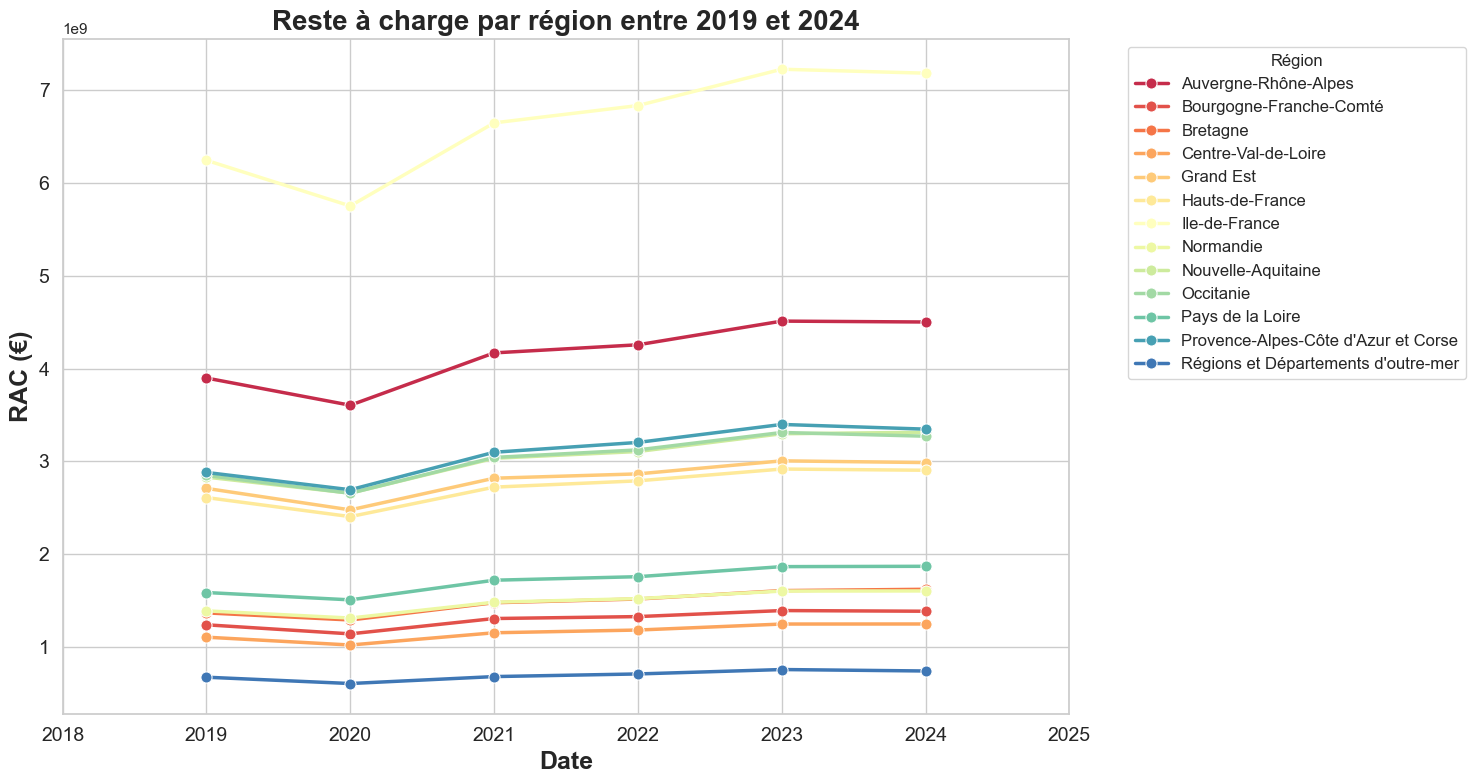

In [15]:
# Définir le style de la visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Tracer une courbe pour visualiser le reste à charge (RAC) par région entre 2019 et 2024
sns.lineplot(
    x="annee",  # Axe des x : années
    y="RAC",  # Axe des y : reste à charge (RAC)
    data=final_df,  # Données utilisées pour la visualisation
    hue="region",  # Différencier les courbes par région
    marker='o',  # Ajouter des marqueurs pour chaque point
    markersize=8,  # Taille des marqueurs
    linewidth=2.5,  # Épaisseur des lignes
    errorbar=None,  # Pas de barres d'erreur
    estimator=np.sum,  # Estimation basée sur la somme des valeurs
    palette="Spectral"  # Palette de couleurs pour différencier les régions
)

# Ajouter un titre avec une taille de police plus grande
plt.title("Reste à charge par région entre 2019 et 2024", fontsize=20, fontweight='bold')

# Ajouter des étiquettes aux axes avec une taille de police plus grande
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("RAC (€)", fontsize=18, fontweight='bold')

# Ajuster la taille des ticks des axes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Ajuster les limites de l'axe des x pour inclure les années de 2018 à 2025
plt.xlim(2018, 2025)

# Placer la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Région", fontsize=12)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()



**Remarque:** les plus grands RAC (totaux) sont enregistrés dans la région d'île de France, succédée par la région Auvergne-Rhône-Alpes

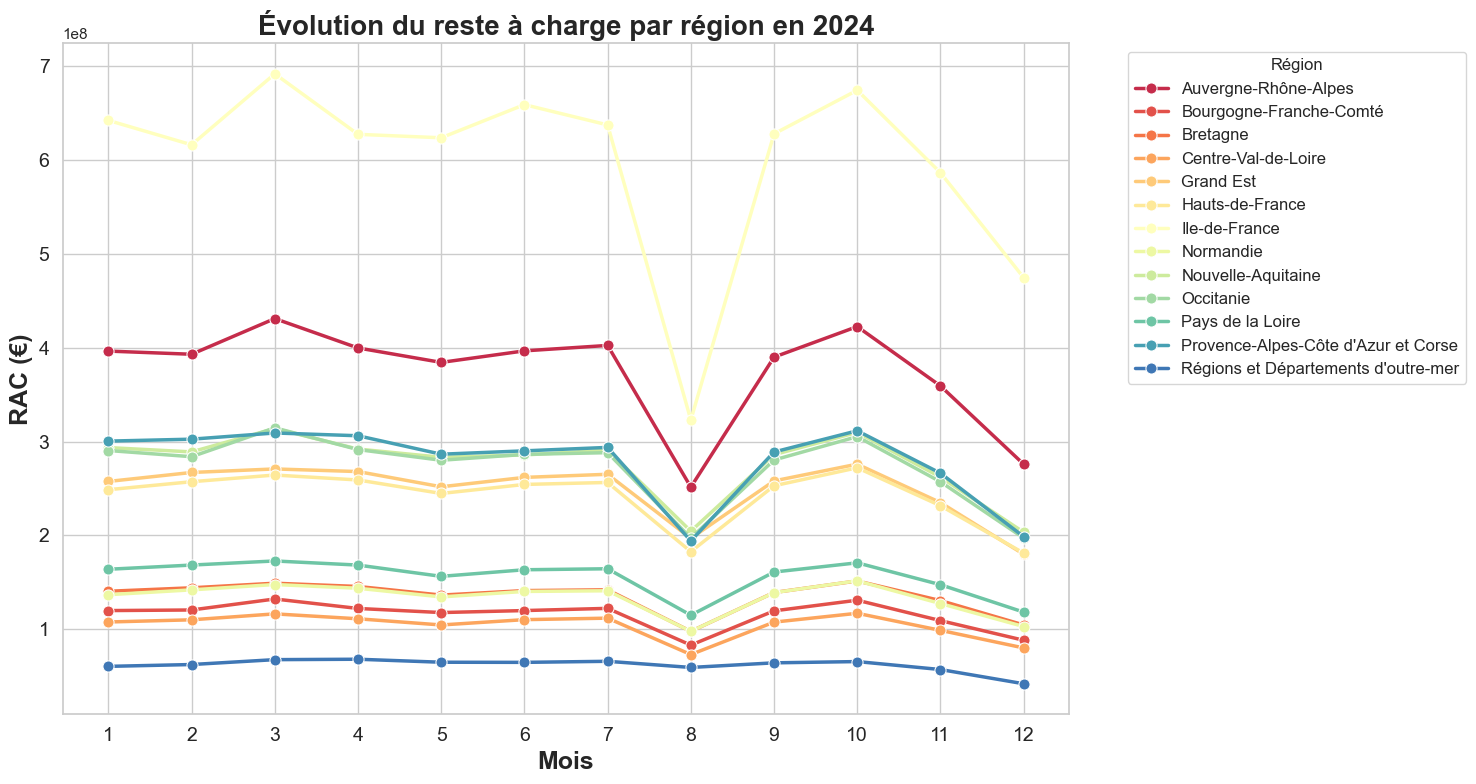

In [16]:
# Filtrer les données pour l'année 2024
final_df_2024 = final_df[final_df['annee'] == 2024]

# Définir le style de la visualisation
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))

# Tracer une courbe pour visualiser l'évolution du reste à charge (RAC) par région en 2024
sns.lineplot(
    x="mois",  # Axe des x : mois
    y="RAC",  # Axe des y : reste à charge (RAC)
    data=final_df_2024,  # Données utilisées pour la visualisation
    hue="region",  # Différencier les courbes par région
    marker='o',  # Ajouter des marqueurs pour chaque point
    markersize=8,  # Taille des marqueurs
    linewidth=2.5,  # Épaisseur des lignes
    errorbar=None,  # Pas de barres d'erreur
    estimator=np.sum,  # Estimation basée sur la somme des valeurs
    palette="Spectral"  # Palette de couleurs pour différencier les régions
)

# Ajouter un titre avec une taille de police plus grande
plt.title("Évolution du reste à charge par région en 2024", fontsize=20, fontweight='bold')

# Ajouter des étiquettes aux axes avec une taille de police plus grande
plt.xlabel("Mois", fontsize=18, fontweight='bold')
plt.ylabel("RAC (€)", fontsize=18, fontweight='bold')

# Ajuster la taille des ticks des axes
plt.xticks([i for i in range(1, 13)], fontsize=14)  # Mois de 1 à 12
plt.yticks(fontsize=14)

# Placer la légende en dehors du graphique
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Région", fontsize=12)

# Ajuster la disposition pour éviter le chevauchement
plt.tight_layout()

# Afficher le graphique
plt.show()



<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Calcul du champ de la dérive de sinistralité</b></h2>

In [17]:
# Filter data for years 2019 to 2023
final_df_N_1 = final_df[(final_df['annee'] <= 2023) & (final_df['annee'] >= 2019)].reset_index(drop=True)

# Filter data for years 2020 and beyond
final_df_N = final_df[final_df['annee'] >= 2020].reset_index(drop=True)

# Ensure both DataFrames have the same length
min_length = min(len(final_df_N), len(final_df_N_1))
final_df_N = final_df_N.iloc[:min_length]
final_df_N_1 = final_df_N_1.iloc[:min_length]

# Calculate the SIN_N/N-1 ratio
final_df_N['SIN_N/N-1'] = final_df_N['RAC_par_personne'].to_numpy() / final_df_N_1['RAC_par_personne'].to_numpy() - 1

# Drop unnecessary columns
final_df_N = final_df_N.drop(columns=['RAC', 'monthly_population', 'RAC_par_personne'])

# Display the resulting DataFrame
SIN_df = final_df_N.copy()

SIN_df.head()

,annee,mois,region,SIN_N/N-1
0,2020,1,Auvergne-Rhône-Alpes,-0.036994
1,2020,2,Auvergne-Rhône-Alpes,0.084782
2,2020,3,Auvergne-Rhône-Alpes,-0.382441
3,2020,4,Auvergne-Rhône-Alpes,-0.696961
4,2020,5,Auvergne-Rhône-Alpes,-0.292180


Text(0.5, 1.0, 'Histogramme des données de la dérive de sinistralité')

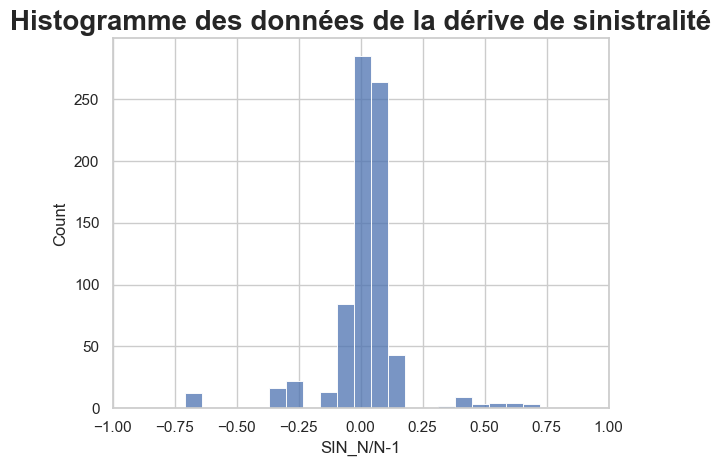

In [29]:
sns.histplot(SIN_df['SIN_N/N-1'], bins = 50)
plt.xlim([-1, 1])
plt.title('Histogramme des données de la dérive de sinistralité', fontdict={"fontweight": "bold", "fontsize" : "20"})

**Remarque:** On remarque un mode positif, ce qui affirme le fait que les prix des soins augmentent d'années en années.

In [31]:
SIN_df['SIN_N/N-1'].mean()

np.float64(0.05570864962019903)

**Remarque:** On observe une augmentation moyenne de la sinistralité de 6% d'année en année.

<h2 style="font-family: Arial, sans-serif; color:rgb(112, 171, 231); font-size: 20px"><b>Chargement des données</b></h2>

In [32]:
SIN_df.to_csv("DBs/SIN_df.csv")